In [1]:
import matplotlib.pyplot as plt
import numpy as np
import utils as ut

# 1. Data importation and preparation

We work with the Adult Census Dataset: https://archive.ics.uci.edu/ml/datasets/adult

The data is processed as in (Besse et al., 2021): https://github.com/XAI-ANITI/StoryOfBias

In [2]:
pre_title = 'adult_'

MyDirWithAdultSensusData='./'

[X_train, X_test, y_train, y_test, S_train, S_test,X_col_names]=ut.read_and_treat_adult_data(MyDirWithAdultSensusData, display=True)

X_train = X_train
y_train = y_train.ravel()
S_train = S_train
y_test = y_test.ravel()

S_train.shape: (32724,)
X_train.shape: (32724, 37)
y_train.shape: (32724, 1)
S_test.shape: (16118,)
X_test.shape: (16118, 37)
y_test.shape: (16118, 1)


# 2. Counterfactual modeling

We compute two empirical counterfactual models: one on the training set, and one on the testing set. For every $s < s' \in \mathcal{S}$, it involves solving the program
$$
    \min_{\pi \in \Sigma(n_s,n_{s'})} \sum_{i \in \mathcal{I}_s} \sum_{j \in \mathcal{I}_{s'}} \pi[i,j] C[i,j],
$$
where

1. $C[i,j] = ||x_i - x_j||^2$,
2. $n_s = \sum^n_{i=1} \mathbf{1}_{\{s_i=s\}}$,
2. $I_s = \{ i=1,\ldots,n \mid s_i=s\}$.

In [3]:
model_train = ut.learn_cf(X_train,S_train)
model_test = ut.learn_cf(X_test,S_test)

# 3. Training regularized and baseline classifiers

The parameter $\lambda$ takes different values accross a grid. We store the evaluation metrics for each value of $\lambda$ and each baseline predictor.

In [4]:
param_list = [1e-4,10**(-3.5),1e-3,10**(-2.5),1e-2,10**(-1.5),1e-1,10**(-0.5),1e0,10**(0.5),1e1]

ACC_list = []
PG_list = []
CFR_list = []

## 3.1. Unaltered classifier

Corresponds to $\lambda = 0$. Presumably the most accurate but also the most unfair predictor.

In [5]:
w = ut.train_classif(X_train,y_train)
y_pred = ut.classifier(X_test,w)

ACC_list.append(np.mean(y_pred==y_test))
PG_list.append(ut.PG(y_pred,S_test))
CFR_list.append(ut.counterfactual_fairness_rate(y_pred,model_test))

## 3.2. Penalized classifiers

Corresponds to $\lambda > 0$. $\lambda$ governs a trade-off between accuracy and counterfactual fairness.

In [6]:
for reg in param_list:

    w = ut.train_classif(X_train,y_train,reg,model_train)
    y_pred = ut.classifier(X_test,w)

    ACC_list.append(np.mean(y_pred==y_test))
    PG_list.append(ut.PG(y_pred,S_test))
    CFR_list.append(ut.counterfactual_fairness_rate(y_pred,model_test))

## 3.3. Constant classifier

Corresponds to the classifier mapping every input to 0.

In [7]:
y_pred = np.zeros(len(y_test))

ACC_list.append(np.mean(y_pred==y_test))
PG_list.append(ut.PG(y_pred,S_test))
CFR_list.append(ut.counterfactual_fairness_rate(y_pred,model_test))

## 4. Evaluation

We plot the evaluation metrics on a logarithmic scale.

In [8]:
param_scale = np.log10(param_list)

### 4.1. Accuracy

In [9]:
metric = ACC_list
title = 'Accuracy'

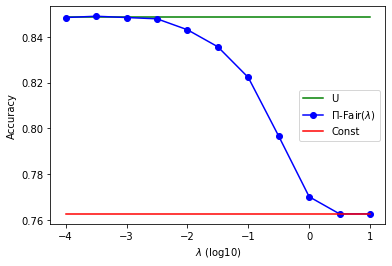

In [10]:
#Unfair
plt.plot(param_scale,[metric[0]]*len(param_scale), color='green', label='U')
#Trade-off
plt.plot(param_scale,metric[1:len(param_scale)+1],
         color='blue',linestyle='solid', marker='o', label='$\Pi$-Fair($\lambda$)')
#Fair
plt.plot(param_scale,[metric[-1]]*len(param_scale), color='red', label='Const')

plt.ylabel(title)
plt.xlabel('$\lambda$ (log10)')
plt.legend()
fig = plt.gcf()
plt.show()

### 4.2. Counterfactual fairness rate

In [11]:
metric = CFR_list
title = 'Counterfactual Fairness Rate'

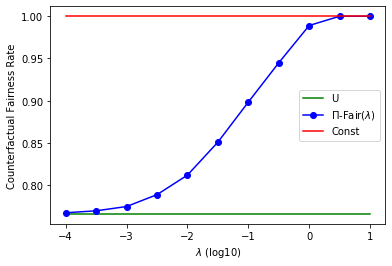

In [12]:
#Unfair
plt.plot(param_scale,[metric[0]]*len(param_scale), color='green', label='U')
#Trade-off
plt.plot(param_scale,metric[1:len(param_scale)+1],
         color='blue',linestyle='solid', marker='o', label='$\Pi$-Fair($\lambda$)')
#Fair
plt.plot(param_scale,[metric[-1]]*len(param_scale), color='red', label='Const')

plt.ylabel(title)
plt.xlabel('$\lambda$ (log10)')
plt.legend()
fig = plt.gcf()
plt.show()

### 4.3. Disparate Impact

In [13]:
metric = PG_list
title = 'Parity Gap'

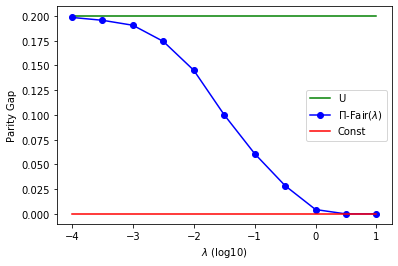

In [14]:
#Unfair
plt.plot(param_scale,[metric[0]]*len(param_scale), color='green', label='U')
#Trade-off
plt.plot(param_scale,metric[1:len(param_scale)+1],
         color='blue',linestyle='solid', marker='o', label='$\Pi$-Fair($\lambda$)')
#Fair
plt.plot(param_scale,[metric[-1]]*len(param_scale), color='red', label='Const')

plt.ylabel(title)
plt.xlabel('$\lambda$ (log10)')
plt.legend()
fig = plt.gcf()
plt.show()